# Assignment 2 - Convolutional Neural Network

## Data processing
First of all, the data sets needs to be processed before feeded into the model training process. Therefore, the provided `load_dataset()` function handles it. Going further with the `ImageFolder` created from `load_dataset`, one can prepare it as `ConcatDataset` type to create a concatenated dataset for K-fold Cross Validation.

In [1]:
from torchvision import transforms, datasets
from matplotlib import pyplot as plt
from torch.utils.data import ConcatDataset
from sklearn.model_selection import KFold


def load_dataset(train_path=r"WF-data/train", test_path=r"WF-data/test"):

    transform = transforms.Compose([transforms.Resize([105, 78]),
                                    transforms.CenterCrop(size=[60, 30]),
                                    transforms.ToTensor()])
    # target_transform = {"ng": 0, "ok": 1}

    train_dataset = datasets.ImageFolder(train_path, transform=transform, target_transform=None)
    test_dataset = datasets.ImageFolder(test_path, transform=transform, target_transform=None)

    return train_dataset, test_dataset


# Creating the data set
train_dataset, test_dataset = load_dataset()
print(f"Datapoints for training is {len(train_dataset)} and for test is {len(test_dataset)}")

# Preparing the K-fold
data_set = ConcatDataset([train_dataset, test_dataset]) # Concatenating it for the K-fold
kfold = KFold(n_splits=5, shuffle=True)

Datapoints for training is 136 and for test is 34


To display a sample of the data set, one can use the `ImageFolder` or even the `ConcatDataset` and permute it to get the RGB colour-spectrum.

(-0.5, 29.5, 59.5, -0.5)

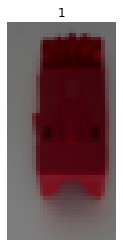

In [2]:
from numpy import random

random_image = random.choice(len(data_set))

img, labels = data_set[random_image][0], data_set[random_image][1]
plt.imshow(img.permute(1,2,0)) # Permutation is used to display the image in RGB instead of gray colormap
plt.title(labels)
plt.axis(False)

## The Model

This Convolutional Neural Network is based on the VGG architecture, which is a good model architecture for detail recognition. To implement it, we can use the [CNN Calculator](https://thanos.charisoudis.gr/blog/a-simple-conv2d-dimensions-calculator-logger) to build the architecture.

In [3]:
import torch.nn as nn
    
class ConvNeuralNet(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self, num_classes=2):
        super(ConvNeuralNet, self).__init__()
        self.layer1 = nn.Sequential(
                                    nn.Conv2d(3, 32, kernel_size = 3, stride = 1, padding = 1),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())
        self.layer2 = nn.Sequential(
                                    nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
                                    nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(
                                    nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.fc1 = nn.Sequential(nn.Dropout(0.5), nn.Linear(7*15*128, 1800), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Dropout(0.5), nn.Linear(1800, 112), nn.ReLU())
        self.dense = nn.Linear(112, num_classes)
    
    # Progresses data across layers    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return self.dense(out)

## Hyperparameters

For the hyperparameters, we define the Cross Entropy loss function and Adam optimiser algorithm. Furthermore, one can tweak around the suitable learning rate in the optimiser. 

In [4]:
import torch
from torch.backends import mps


# Creating the Early Stopping class
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if abs(validation_loss - train_loss) < self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

# Define model, loss function, optimizer and other hyper-parameters
import torch.optim as optim
dev = torch.device('mps' if mps.is_available() else 'cpu') # GPU support for PyTorch in MacOS
# dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # GPU support for PyTorch if CUDA is available


model = ConvNeuralNet() # Based on VGG architecture
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=3, min_delta=0.1)


## Training 

In [ ]:
from tqdm.notebook import tqdm as tqdm
from torch.utils.data import DataLoader

def train(model, num_epochs, train_loader, test_loader, criterion, optimizer, early_stopping, dev):
    train_log = {'acc': [], 'loss': []}
    val_log = {'acc': [], 'loss': []}
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct, train_total = 0.0, 0.0

        for _, (images, labels) in enumerate(tqdm(train_loader, position=0, leave=True, ascii=False)):
            
            images, labels = images.to(dev), labels.to(dev)

            optimizer.zero_grad() # Zero out the gradients for initialisation
            outputs = model(images) # Compute output for Forward pass
            loss = criterion(outputs, labels) # Compute loss
            loss.backward() # Perform backpropagation step
            optimizer.step() # Update the weights

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        train_loss /= len(train_loader)
        train_accuracy = train_correct / train_total
        train_log['acc'].append(train_accuracy)
        train_log['loss'].append(train_loss)
        

    # Validation Process
        with torch.no_grad(): 
            valid_correct, valid_total = 0.0, 0.0
            valid_loss = 0
            model.eval()
            for _, (images, labels) in enumerate(tqdm(test_loader, position=0, leave=False, ascii=False)):
                images, labels = images.to(dev), labels.to(dev)
                
                outputs = model(images)

                _, predicted = torch.max(outputs.data, 1)
                valid_correct += (predicted == labels).sum().item()
                valid_total += labels.size(0)
                valid_loss += criterion(outputs, labels).item()
            
            valid_accuracy = 100*valid_correct/valid_total
            valid_loss /= len(test_loader)

        # Early Stopping for avoiding overfit
        print(f'Epoch {epoch+1}: Train Loss= {train_loss:.3f}, Train Accuracy: {100*train_accuracy:.3f}%, Validation Loss = {valid_loss:.2f}, Validation Accuracy = {valid_accuracy:.2f}%') 

        # Keeping the metrics
        val_log['acc'].append(train_accuracy)
        val_log['loss'].append(train_loss)

        
        # Early stopping
        if early_stopping(valid_loss, train_loss):
            print("We are at epoch:", epoch)
            break

    print('Finished training')
    return model, train_log, val_log


# Create data loaders
batch_size = 5
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 30

trained_model, train_log, val_log =  train(model, num_epochs, train_loader, test_loader, criterion, optimizer, early_stopping, dev)

## Training code (K-folds)

In this part, we defined the training of the CNN model. Furthermore, we are specifying it for 30 epochs.

In [5]:
from tqdm.notebook import tqdm as tqdm
from torch.utils.data import SubsetRandomSampler, DataLoader
from torch.backends import mps
import numpy as np

def training_Kfold(model, num_epochs, data_set, kfold, criterion, optimizer, save_model=True, savepath="CNN_model.pth"):
    """
    Training function
    -----------------
    Input:
        model: PyTorch model
        num_epochs: Number of maximum epochs
        train_loader: DataLoader type dataset for training
        test_loader: DataLoader type dataset for validation
        criterion: Loss function
        optimizer: Optimizer function for the training
        early_stopping: EarlyStopping functionality 
        save_model: If True, then it saves the model parameters
    Output:
        model: Trained PyTorch model
        training_log: Data of the training results for further use
    """
    
    def reset_weights(m):
        '''
        Try resetting model weights to avoid weight leakage.
        '''
        for layer in m.children():
            if hasattr(layer, 'reset_parameters'):
                # print(f'Reset trainable parameters of layer = {layer}')
                layer.reset_parameters()


    torch.manual_seed(42) # Set fixed random number seed for reproducibility
    dev = torch.device('mps' if mps.is_available() else 'cpu') # GPU support for PyTorch in MacOS
    train_log = {'loss': []}
    fold_log = {'acc': []}


    for fold, (train_ids, test_ids) in enumerate(kfold.split(data_set)):

        print(f'FOLD {fold+1}')
        print('--------------------------------')
    
        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = SubsetRandomSampler(train_ids)
        test_subsampler = SubsetRandomSampler(test_ids)
    
        # Define data loaders for training and testing data in this fold
        train_loader = DataLoader(data_set, batch_size=5, sampler=train_subsampler)
        test_loader = DataLoader(data_set, batch_size=5, sampler=test_subsampler)

        model.apply(reset_weights)
        model.to(dev)
        train_loss, train_accuracy = 0.0, 0.0

        for epoch in range(num_epochs):
            current_train_loss = 0.0
            # train_correct, train_count = 0.0, 0.0

            for _, (images, labels) in enumerate(train_loader):
                
                images = images.to(dev)
                labels = labels.to(dev)

                optimizer.zero_grad() # Zero out the gradients for initialisation
                outputs = model(images) # Compute output for Forward pass
                loss = criterion(outputs, labels) # Compute loss
                loss.backward() # Perform backpropagation step
                optimizer.step() # Update the weights

                current_train_loss += loss.item()
                # _, predicted = torch.max(outputs.data, 1)
                # train_correct += (predicted == labels).sum().item()
                # train_count += labels.size(0) 

            current_train_loss /= len(train_loader)
            # current_train_accuracy = train_correct / train_count
            print(f"Epoch {epoch+1} Training: loss = {current_train_loss:.3f}")
            train_loss += current_train_loss
            # train_accuracy += current_train_accuracy

        
        print('Finished training \n')
        if save_model: torch.save(model.state_dict(), savepath)

        # Validation Process
        valid_correct, valid_total = 0, 0
        with torch.no_grad(): 
            # valid_loss = 0
            for _, (images, labels) in enumerate(test_loader):
                images, labels = images.to(dev), labels.to(dev)
                outputs = model(images)

                _, predicted = torch.max(outputs.data, 1)
                valid_correct += (predicted == labels).sum().item()
                valid_total += labels.size(0)
                
        # Printing and saving the metrics for later use
        print(f'Accuracy for fold {fold+1} = {100*valid_correct / valid_total:.3f}%\n')
        train_log['loss'].append(train_loss/num_epochs)
        fold_log['acc'].append(valid_correct/valid_total)

    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {fold+1} FOLDS')
    print('----------------------------------------------------')
    print(f"Average Accuracy = {np.mean(fold_log['acc'])*100:.2f}%")

    return model.to("cpu"), train_log, fold_log

trained_model, loss_log, test_log = training_Kfold(model, num_epochs=30, data_set=data_set, 
                                                   kfold=kfold, criterion=criterion, optimizer=optimizer, 
                                                   save_model=True, savepath="CNN_model.pth")


def test(trained_model, test_dataset, batch_size=5):
    """
    Testing the trained model with K-fold
    """
    test_loader = DataLoader(test_dataset, batch_size, shuffle=True)
    with torch.no_grad():
        test_correct, test_total = 0.0, 0.0
        for _, (images, labels) in enumerate(test_loader):
            outputs = trained_model(images)

            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
        
        test_acc = test_correct/test_total
    print(f"Test accuracy = {test_acc*100:.2f}%")

test(trained_model, test_dataset, batch_size=5)

FOLD 1
--------------------------------
Epoch 1 Training: loss = 0.697
Epoch 2 Training: loss = 0.672
Epoch 3 Training: loss = 0.648
Epoch 4 Training: loss = 0.619
Epoch 5 Training: loss = 0.629
Epoch 6 Training: loss = 0.573
Epoch 7 Training: loss = 0.547
Epoch 8 Training: loss = 0.519
Epoch 9 Training: loss = 0.484
Epoch 10 Training: loss = 0.458
Epoch 11 Training: loss = 0.491
Epoch 12 Training: loss = 0.413
Epoch 13 Training: loss = 0.481
Epoch 14 Training: loss = 0.472
Epoch 15 Training: loss = 0.402
Epoch 16 Training: loss = 0.372
Epoch 17 Training: loss = 0.370
Epoch 18 Training: loss = 0.366
Epoch 19 Training: loss = 0.348
Epoch 20 Training: loss = 0.315
Epoch 21 Training: loss = 0.368
Epoch 22 Training: loss = 0.337
Epoch 23 Training: loss = 0.305
Epoch 24 Training: loss = 0.293
Epoch 25 Training: loss = 0.295
Epoch 26 Training: loss = 0.280
Epoch 27 Training: loss = 0.291
Epoch 28 Training: loss = 0.230
Epoch 29 Training: loss = 0.294
Epoch 30 Training: loss = 0.284
Finished 